In [115]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

# General imports
import numpy as np
import re

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [24]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=complex)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [129]:
def convert_qiskit_pauli_string(s):
    # Find all characters followed by a number in brackets
    matches = re.findall(r'([A-Za-z])\((\d+)\)', s)

    # Sort the matches based on the order number (second element in tuple)
    sorted_matches = sorted(matches, key=lambda x: int(x[1]))

    # Join the characters in the sorted order
    return ''.join([char for char, _ in sorted_matches])

In [183]:
# Example usage for a 4x4 matrix
cut_off = 2
q = create_matrix(cut_off, 'q')
p = create_matrix(cut_off, 'p')
H = np.matmul(q,q) + np.matmul(p,p) - 0.5

pauli_decomposed = qml.pauli_decompose(H)
coeffs = pauli_decomposed.coeffs

paulis = []

for x in pauli_decomposed.terms()[1]:
    paulis.append(convert_qiskit_pauli_string(str(x)))


In [184]:
hamiltonian = SparsePauliOp(paulis, coeffs=coeffs)
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [185]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [186]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [187]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.6128999999999998]
Iters. done: 2 [Current cost: 0.4958999999999998]
Iters. done: 3 [Current cost: 0.13459999999999978]
Iters. done: 4 [Current cost: 0.24539999999999978]
Iters. done: 5 [Current cost: 0.37009999999999976]
Iters. done: 6 [Current cost: 0.021599999999999786]
Iters. done: 7 [Current cost: 0.15169999999999978]
Iters. done: 8 [Current cost: 0.12369999999999975]
Iters. done: 9 [Current cost: 0.11599999999999977]
Iters. done: 10 [Current cost: 0.006699999999999762]
Iters. done: 11 [Current cost: 0.011699999999999766]
Iters. done: 12 [Current cost: 0.0370999999999998]
Iters. done: 13 [Current cost: 0.009799999999999753]
Iters. done: 14 [Current cost: 0.010499999999999787]
Iters. done: 15 [Current cost: 0.05479999999999979]
Iters. done: 16 [Current cost: 0.002599999999999769]
Iters. done: 17 [Current cost: 0.025199999999999778]
Iters. done: 18 [Current cost: 0.030199999999999783]
Iters. done: 19 [Current cost: 0.09499999999999975]
Iters. done: 20 

In [188]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 9.999999999976694e-05
       x: [ 5.625e+00  5.060e+00  4.931e+00  2.852e+00  5.681e+00
            5.742e+00  4.612e+00  1.904e+00]
    nfev: 85
   maxcv: 0.0

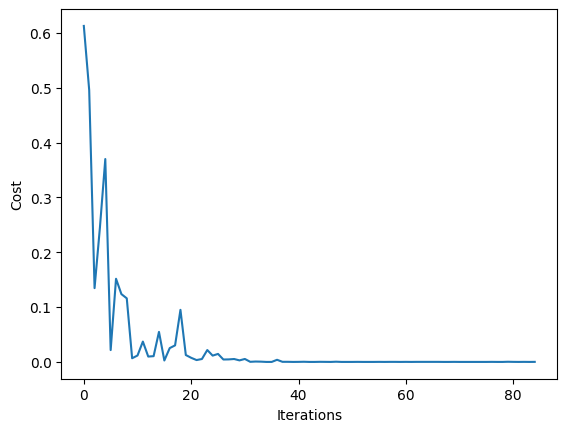

In [189]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()